[-51281.81379517596 29016.76454955565] 114484.08283375703
[-71395.72708587289 81078.87009528796] 107503.55165114897
[-71861.41385293535 60687.35043936914] 117613.59480250353
[-71310.98884225069 -30807.0509001474] 160642.5235492044
[-73463.29896648611 -46964.694945950105] 170229.8702592665
-156.7188484887845


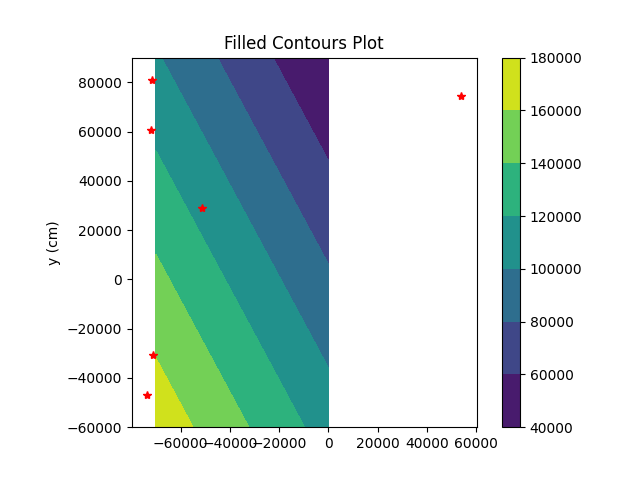

In [84]:
import numpy as np
from UTILS.tensor_ops import dir2rad, np_softmax, reg_rad_at, reg_rad, repeat_at, avg_rad

       
def reg_rad(rad):
    # it's OK to show "RuntimeWarning: invalid value encountered in remainder"
    return (rad + np.pi) % (2 * np.pi) - np.pi

def test_rank(center, q, phi0, alpha_deg, polar=1):
    delta = q-center
    d = np.linalg.norm(delta)
    phi = (np.arctan2(delta[1],delta[0])-phi0)*polar
    alpha = alpha_deg * (np.pi/180)
    small_first_rank = d*np.cos(phi) - d*np.sin(phi)*np.tan(alpha) 
    return small_first_rank




def dir2rad(delta_pos):
    result = np.empty(delta_pos.shape[:-1], dtype=complex)
    result.real = delta_pos[..., 0]
    result.imag = delta_pos[..., 1]
    rad_angle = np.angle(result)
    return rad_angle

def reg_rad_at(rad, ref):
    return reg_rad(rad-ref) + ref

def get_points_angle_deg(pt1, pt_center, pt2):
    vec_p2op_01 = pt_center - pt1
    vec_p2op_02 = pt_center - pt2
    dir_01 = dir2rad(vec_p2op_01)
    dir_02 = dir2rad(vec_p2op_02)

    dir_02 = reg_rad_at(dir_02, ref=dir_01)
    delta_rad = np.abs(dir_02-dir_01) # 弧度制的攻击角度差
    delta_deg = delta_rad * 180/np.pi
    return delta_deg


q_list = np.array([
    [0,     1],
    [1.5,   1.5],
    [-1,    +1],
    [-0.5,  4],
    [0,     0.5],
])
all_my_plane_center = np.array([53880.569, 74265.836])

q_list = np.array([[-51281.81379517596, 29016.76454955565],
       [-71395.72708587289, 81078.87009528796],
       [-71861.41385293535, 60687.35043936914],
       [-71310.98884225069, -30807.0509001474],
       [-73463.29896648611, -46964.694945950105]], dtype=object)

polar = -1
alpha_deg = 5

angle = -9999
op1_tmp = None
op2_tmp = None

for op1 in q_list:
    for op2 in q_list:

        delta_deg = get_points_angle_deg(pt1=op1, 
            pt_center=all_my_plane_center, 
            pt2=op2)

        if delta_deg > angle:
            angle = delta_deg
            op1_tmp = op1
            op2_tmp = op2
rad1 = dir2rad(op1_tmp-all_my_plane_center)
rad2 = dir2rad(op2_tmp-all_my_plane_center)
# phi0 = avg_rad(rad1, rad2)
phi0 = dir2rad(q_list[0]-all_my_plane_center)


for q in q_list:
    print(q,
        test_rank(
            center = all_my_plane_center, 
            q = q, 
            phi0 = phi0,
            alpha_deg = alpha_deg,
            polar=polar
        )
    )



print(phi0*180/np.pi)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget

xlist = np.linspace(-70000.0, 0, 100)
ylist = np.linspace(-60000, 90000, 100)
X, Y = np.meshgrid(xlist, ylist)

XY_ = np.stack((X.reshape(-1),Y.reshape(-1)),-1)
Z_ = np.zeros_like(X.reshape(-1))

for i, (x_, y_) in enumerate(XY_):
    Z_[i] = test_rank(
        center = all_my_plane_center, 
        q = np.array([x_,y_]), 
        phi0 = phi0,
        alpha_deg = alpha_deg,
        polar=polar
    )#center, q, phi0, alpha_deg, polar=1

Z = Z_.reshape(100,100)
fig,ax=plt.subplots(1,1)
cp = ax.contourf(X, Y, Z)
ax.plot(q_list[:,0],q_list[:,1],'r*')
ax.plot(all_my_plane_center[0],all_my_plane_center[1],'r*')
ax.set_aspect('equal', 'box')
fig.colorbar(cp) # Add a colorbar to a plot
ax.set_title('Filled Contours Plot')
#ax.set_xlabel('x (cm)')
ax.set_ylabel('y (cm)')
plt.show()


In [10]:
import numpy as np
import pyximport; pyximport.install(build_dir='./RECYCLE/build/', inplace=True, language_level=3, setup_args={'include_dirs': np.get_include()})

from UTILS.tensor_ops_c import reg_rad_arr

In [1]:
import numpy as np
import os
from UTILS.tensor_ops import dir2rad
os.remove('UTILS/tensor_ops_c.cpython-38-x86_64-linux-gnu.so')
import pyximport; pyximport.install(build_dir='./RECYCLE/build/', inplace=True, language_level=3, setup_args={'include_dirs': np.get_include()})

from UTILS.tensor_ops_c import reg_rad_arr


ImportError: cannot import name 'reg_rad_arr' from 'UTILS.tensor_ops_c' (/home/fuqingxu/2022/hmp-2g/UTILS/tensor_ops_c.cpython-38-x86_64-linux-gnu.so)

In [59]:
from UTILS.tensor_ops import dir2rad, reg_rad
pos2d = np.random.rand(100,2) 
t = np.random.rand(100)


import time
tic = time.time()
def x():
    for i in range(100000):
        q = dir2rad(pos2d) + t
        qq = reg_rad(q)
x()
print('time：：：：', time.time()-tic)

time：：：： 1.644561767578125


In [6]:
load_ext Cython

In [45]:
%%cython

import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import prange
from libc.math cimport cos, atan2, abs
from UTILS.tensor_ops import my_view
np.import_array()
ctypedef fused Dtype:
    double

cdef double PI = np.pi


def dir2rad_smart(delta_pos):
    o_shape = delta_pos.shape
    res = dir2rad_arr2d(my_view(delta_pos, [-1, 0]).astype(np.double))
    return res.reshape(o_shape[:-1])


def reg_rad_smart(rad):
    o_shape = rad.shape
    rad1d = my_view(rad, [-1]).astype(np.double)
    res = reg_rad_arr1d(rad1d)
    return res.reshape(o_shape)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def dir2rad_arr2d(Dtype [:,:] delta_pos):
    # cdef Dtype [:] iiiiii = my_view(rad, [-1])

    cdef Py_ssize_t batch = delta_pos.shape[0]
    cdef Py_ssize_t b
    result = np.zeros(batch, dtype=np.double)
    cdef Dtype[:] result_view = result

    for b in prange(batch, nogil=True):
        result_view[b] = atan2(delta_pos[b, 1], delta_pos[b, 0])
    return result


@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
def reg_rad_arr1d(Dtype [:] rad_view):
    # cdef Dtype [:] iiiiii = my_view(rad, [-1])

    cdef Py_ssize_t dim = rad_view.shape[0]
    cdef Py_ssize_t x, y

    result = np.zeros(dim, dtype=np.double)
    cdef Dtype[:] result_view = result

    for x in prange(dim, nogil=True):
        result_view[x] = (rad_view[x] + PI) % (2*PI) - PI
    return result
    

In [51]:


from UTILS.tensor_ops import dir2rad, reg_rad, repeat_at
pos2d = np.random.rand(2, 100, 2) 
pos2d = np.array([
    [1,1],
    [1,-1],
    [-1,1],
    [-1,-1],
])
pos2d = np.array(
    [1,1])
# pos2d = repeat_at(pos2d, 0, 2)
# t = np.random.rand(100)
q = dir2rad_smart(pos2d)
qq = reg_rad_smart(q)
print(qq.shape)
print(qq*180/np.pi)


()
45.0


In [10]:
import numpy as np

def pt2LineDis(Pt, Lpt1, Lpt2):
    q1=Lpt1-Pt
    q2=Lpt2-Pt
    q3=Lpt1-Lpt2
    return np.cross(q1,q2)/np.linalg.norm(q3)

def pts2LineDisWithRef(Pts, PtPosRef, Lpt1, Lpt2):
    DisRes = np.array([pt2LineDis(Pt, Lpt1, Lpt2) for Pt in Pts])
    if pt2LineDis(PtPosRef, Lpt1, Lpt2) < 0:
        DisRes = -DisRes
    return DisRes

p1 = np.array([1,0])
p2 = np.array([-1,0])

p3 = np.array([1,1.5])

pts2LineDisWithRef(
    Pts=[np.array([1,2]), np.array([-1,2.5]), np.array([-1,-2.5])],
    PtPosRef = np.array([1,99]),
    Lpt1=p1,
    Lpt2=p2
)


# pt2LineDis(Pt=p3, Lpt1=p1, Lpt2=p2)


array([ 2. ,  2.5, -2.5])

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# this sets up the Matplotlib interactive windows:
%matplotlib widget
# this changes the default date converter for better interactive plotting of dates:
plt.rcParams['date.converter'] = 'concise'

#   Note the use of datetimes in the file complicate loading a bit.
#   We recommend using pandas or xarray for more elegant solutions
#   to handling complex timeseries data. 
with open('RECYCLE/small.txt', 'r') as f:
    data = np.genfromtxt(f, dtype='datetime64[s],f,f,f', 
                         names=['date', 'doy', 'temp', 'solar'])
datetime = data['date']
dayofyear = data['doy']
temperature = data['temp']
solar = data['solar']

# make two-day smoothed versions:
temp_low = np.convolve(temperature, np.ones(48)/48, mode='same')
solar_low = np.convolve(solar, np.ones(48)/48, mode='same')

fig, (ax0, ax1) = plt.subplots(2, 1, sharex=True, constrained_layout=True)

# temperature:
ax0.plot(datetime, temperature, label='hourly')
ax0.plot(datetime, temp_low, label='smoothed')
ax0.legend(loc='upper right')
ax0.set_ylabel('Temperature $[^oC]$')  # note the use of TeX math formatting

# solar-radiation:
ax1.plot(datetime, solar, label='hourly')
ax1.plot(datetime, solar_low, label='smoothed')
ax1.legend(loc='upper right')
ax1.set_ylabel('Solar radiation $[W\,m^{-2}]$')   # note the use of TeX math formatting

ax0.set_title('Observations: Dinosaur, Colorado', loc='left')
ax0.text(0.03, 0.03, 'https://www.ncei.noaa.gov/pub/data/uscrn/products/hourly02/', 
         fontsize='small', fontstyle='italic', transform=ax0.transAxes);

FileNotFoundError: [Errno 2] No such file or directory: 'data/small.txt'

In [9]:
%%cython

a: cython.int = 0
for i in range(10):
    a += i
print(a)

45


In [75]:
pos_o = np.array([0.0, 0.0])
fanRadius = 2.0
fanOpenRad = PI/2 # 90 deg
fanDirRad =  0 # ? deg

for theta in np.arange(-180, 180, 10):
    theta_rad = theta*PI/180
    pos_t = np.array([np.cos(theta_rad), np.sin(theta_rad)])
    print(theta, laser_hit_improve3(pos_o, pos_t, fanRadius, fanOpenRad, fanDirRad))

-180 False
-170 False
-160 False
-150 False
-140 False
-130 False
-120 False
-110 False
-100 False
-90 False
-80 False
-70 False
-60 False
-50 False
-40 True
-30 True
-20 True
-10 True
0 True
10 True
20 True
30 True
40 True
50 False
60 False
70 False
80 False
90 False
100 False
110 False
120 False
130 False
140 False
150 False
160 False
170 False


atan2(y,x)

In [42]:
import numpy as np
deg = [ np.arccos(i/100)*np.pi/180  for i in range(-100,100)]
deg

[0.05483113556160754,
 0.05236080573055761,
 0.051334632956605425,
 0.05054520875160189,
 0.04987799395815786,
 0.04928866049642385,
 0.04875449214682576,
 0.048262004545041336,
 0.04780241817608512,
 0.047369638945661235,
 0.04695923268098997,
 0.046567854019832496,
 0.04619290547647732,
 0.04583232254906506,
 0.04548443221163199,
 0.04514785630971444,
 0.04482144358609045,
 0.044504220604608936,
 0.04419535552319032,
 0.04389413082991245,
 0.0435999224729305,
 0.04331218364235137,
 0.04303043199658701,
 0.04275423947943935,
 0.04248322411347368,
 0.042217043320338814,
 0.04195538843463453,
 0.04169798016066698,
 0.041444564781350696,
 0.04119491097249394,
 0.04094880710838298,
 0.04070605896914274,
 0.04046648777900686,
 0.040229928518940125,
 0.0399962284681325,
 0.03976524593753071,
 0.039536849165377336,
 0.03931091535012165,
 0.03908732980037239,
 0.03886598518502331,
 0.03864678086948082,
 0.0384296223261989,
 0.03821442060958808,
 0.038001091886896154,
 0.037789557017922824,
 0

In [ ]:
confidence_threshhold = 0.25*1.05
eye_mat = np_repeat_at(np.eye(n_agent), insert_dim=0, n_times=n_timestep)
compasion_matrix = correct_prediction & (prediction_rating > confidence_threshhold) & not_zero_mask | (eye_mat==1)
print(compasion_matrix)

In [ ]:
# compasion_matrix = (prediction_rating > confidence_threshhold) & not_zero_mask & (eye_mat==0)
compasion_matrix = compasion_matrix.astype(np.int)

# 计算分解后的reward，因为reward可能被多个智能体分解
n_com = compasion_matrix.sum(-2)
assert not (n_com==0).any()
reward_decmp = np.where(n_com!=0, reward/n_com, reward) # reward/(n_com+1e-7)
# https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
compassion_reward = np.matmul(compasion_matrix, np.expand_dims(reward_decmp,-1)).squeeze(-1)
print(compassion_reward)

In [ ]:
'''
函数说明：在有限的、不均衡的多标签数据集中，按照预设的比例，取出尽可能多的样本
'''
def sample_balance(x, y, n_class, weight=None):
    if weight is None: weight = torch.ones(n_class, device=x.device)
    else: weight = torch.Tensor(weight, device=x.device)
    n_instance = torch.zeros(n_class, device=x.device)
    indices = [None]*n_class
    for i in range(n_class):
        indices[i] = torch.where(y==i)[0]
        n_instance[i] = len(indices[i])
    ratio = n_instance/weight
    bottle_neck = torch.argmin(n_instance/weight)
    r = ratio[bottle_neck]
    n_sample = (r*weight).long()
    # print(n_instance, n_sample)
    new_indices = [indices[i][torch.randperm(n_sample[i])] for i in range(n_class)]
    # print(new_indices)
    new_indices_ = torch.cat(new_indices)
    assert len(new_indices_) == sum(n_sample)
    return x[new_indices_], y[new_indices_]

'''
测试代码
'''
x = torch.rand(200, 4)
y1 = torch.rand(100, 4)
y2 = torch.rand(100, 4)
y2[:, 0] += 1
y = torch.cat((y1,y2))
y = torch.argmax(y, -1)
print(y)
n_class = 4
weight = [2,1,1,1]
sample_balance(x,y,4,weight)

In [ ]:
x = torch.rand(100, 4)
y = torch.rand(100, 4)
y = torch.argmax(y, -1)

# return x[new_indices_], y[new_indices_]

In [ ]:
import numpy as np
def my_view(x, shape):
    if -1 in shape[1:-1]: return my_view_test(x, shape)
    reverse_lookup = True if shape[0] == -1 else False
    if not reverse_lookup:
        for i, dim in enumerate(shape):
            if dim == 0:
                shape[i] = x.shape[i]
    else:
        for i in range(len(shape)):
            ni = -(i + 1)  # iter -1,-2,-3,...
            dim = shape[ni]
            if dim == 0:
                shape[ni] = x.shape[ni]
    if isinstance(x, np.ndarray):
        return x.reshape(*shape)
    return x.view(*shape)

def my_view_test(x, shape):
    # fill both way until meet -1 
    for i, dim in enumerate(shape):
        if dim == 0: shape[i] = x.shape[i]
        elif dim == -1: break
    for i in range(len(shape)):
        ni = -(i + 1); dim = shape[ni]
        if dim == 0: shape[ni] = x.shape[ni]
        elif dim == -1: break
    # print(shape)
    if isinstance(x, np.ndarray):
        return x.reshape(*shape)
    return x.view(*shape)



In [ ]:

"""
    improve np.reshape and torch.view function
    If a dim is assigned with 0, it will keep its original dimension
    eg.1    x.shape = (4, 5, 6, 7); new_shape = [0, 0, -1]
            y = my_view(x, new_shape)
            y.shape = (4, 5, 6*7)

    eg.2    x.shape = (4, 5, 6, 7); new_shape = [-1, 0, 0]
            y = my_view(x, new_shape)
            y.shape = (4*5, 6, 7)

(4, 5, 6); new_shape = [0, 0, -1, 3]

(4, 5, 6); new_shape = [2, -1, 0, 0]
(3, 4, 5, 6); new_shape = [0, 2, -1, 0, 0]
"""

my_view(np.zeros(shape=(4, 5, 6)), shape = [2, -1, 0, 0]).shape

In [ ]:
my_view(np.zeros(shape=(4, 5, 6)), shape = [0, 0, -1, 3]).shape

In [ ]:
load_ext Cython

In [ ]:
%%cython



In [ ]:
new_method(np.ones(5), np.zeros(5))